![](img/330-banner.png)

# Lecture 4: Distances, $k$-nearest neighbours, Imputation, Scaling  

UBC 2020-21

Instructor: Varada Kolhatkar

## Lecture learning objectives

From this lecture, you will be able to 

- explain the notion of similarity-based algorithms; 
- broadly describe how $k$-NNs use distances; 
- discuss the effect of using a small/large value of the hyperparameter $k$ when using the $k$-NN algorithm; 
- describe the problem of curse of dimensionality; 
- explain the general idea of SVMs with RBF kernel;
- broadly describe the relation of `gamma` and `C` hyperparameters of SVMs with the fundamental tradeoff.

## Imports

In [1]:
import sys

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from IPython.display import HTML

sys.path.append("code/.")

import mglearn
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from utils import *
from ipywidgets import interactive
%matplotlib inline

pd.set_option("display.max_colwidth", 200)

## Motivation and big picture <a name="1"></a>

### Analogy-based models

- Suppose you are given the following training examples with corresponding labels and are asked to label a given test example.

<img src='./img/knn-motivation.png' width="1500">

[source](https://vipl.ict.ac.cn/en/database.php)

- An intuitive way to classify the test example is by finding the most "similar" example(s) from the training set and using that label for the test example.  

### Analogy-based algorithms in practice

- [Herta's High-tech Facial Recognition](https://www.hertasecurity.com/en)
    - Feature vectors for human faces 
    - $k$-NN to identify which face is on their watch list
- Recommendation systems     

### General idea of $k$-nearest neighbours algorithm

- Consider the following toy dataset with two classes.
    - blue circles $\rightarrow$ class 0
    - red triangles $\rightarrow$ class 1 
    - green stars $\rightarrow$ test examples

In [2]:
X, y = mglearn.datasets.make_forge()
X_test = np.array([[8.2, 3.66214339], [9.9, 3.2], [11.2, 0.5]])

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


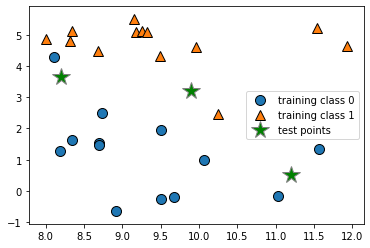

In [3]:
plot_train_test_points(X, y, X_test)

- Given a new data point, predict the class of the data point by finding the "closest" data point in the training set, i.e., by finding its "nearest neighbour" or majority vote of nearest neighbours. 

In [4]:
def f(n_neighbors):
    print(n_neighbors)
    return plot_knn_clf(X, y, X_test, n_neighbors=n_neighbors)

interactive(children=(IntSlider(value=1, description='n_neighbors', max=7, min=1, step=2), Output()), _dom_cla…

<function __main__.f(n_neighbors)>

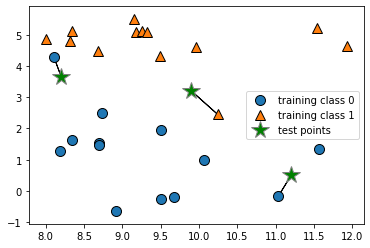

In [7]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

interact(
    f, n_neighbors=widgets.IntSlider(min=1, max=7, step=2, value=1),
)


In [ ]:
plot_knn_clf(X, y, X_test, n_neighbors=1)

In [ ]:
plot_knn_clf(X, y, X_test, n_neighbors=3)

## Distances 

### Geometric view of tabular data and dimensions 

- To understand analogy-based algorithms it's useful to think of data as points in a high dimensional space. 
- Our `X` represents the the problem in terms of relevant **features** ($d$) with one dimension for each **feature** (column).
- Examples are **points in a $d$-dimensional space**. 

How many dimensions (features) are there in the cities data?

In [ ]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
X_cities = cities_df[["longitude", "latitude"]]
y_cities = cities_df["country"]

In [ ]:
mglearn.discrete_scatter(X.iloc[:, 0], X.iloc[:, 1], y)
plt.xlabel("longitude")
plt.ylabel("latitude");

- Recall the [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset from homework 1. 
- How many dimensions (features) we used in the homework? 

In [ ]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)
X_spotify = spotify_df.drop(columns=["target", "song_title", "artist"])
print("The number of features in the Spotify dataset: %d" % X_spotify.shape[1])
X_spotify.head()

### Feature vectors 

**Feature vector**
: is composed of feature values associated with an example.

In [ ]:
print(
    "An example feature vector from the cities dataset: %s" % (X_cities.iloc[0].to_numpy())
)
print(
    "An example feature vector from the Spotify dataset: \n%s" % (X_spotify.iloc[0].to_numpy())
)

### Dimensions in ML problems 

In ML, usually we deal with high dimensional problems where examples are hard to visualize.  

- $d \approx 20$ is considered low dimensional
- $d \approx 1000$ is considered medium dimensional 
- $d \approx 100,000$ is considered high dimensional 

### Feature vectors 

**Feature vector**
: is composed of feature values associated with an example.

Some example feature vectors are shown below. 

In [ ]:
two_cities = train_df.sample(2, random_state=42).drop(columns=["country"])
two_cities

In [ ]:
plt.scatter(canada["longitude"], canada["latitude"], color="red", alpha=0.4)
plt.scatter(usa["longitude"], usa["latitude"], color="blue", alpha=0.4)
plt.scatter(two_cities["longitude"], two_cities["latitude"], color="black", s=300)
plt.ylabel("latitude")
plt.xlabel("longitude");

### Similarity between examples

Let's take 2 points (two feature vectors) from the cities dataset.

In [ ]:
# Let's take 2 points (two feature vectors) from the cities dataset.
two_cities = X_cities.sample(2, random_state=1)
two_cities

In [ ]:
mglearn.discrete_scatter(X_cities.iloc[:, 0], X_cities.iloc[:, 1], y_cities, s=8);
mglearn.discrete_scatter(two_cities.iloc[:, 0], two_cities.iloc[:, 1],markers="*", c='g', s=18);


### Distance between vectors 

- For the cities at the two big circles, what is the _distance_ between them?
- A common way to calculate the distance between vectors is calculating the **Euclidean distance**. 
- The euclidean distance between vectors $u = <u_1, u_2, \dots, u_n>$ and $v = <v_1, v_2, \dots, v_n>$ is defined as: 

$$distance(u, v) = \sqrt{\sum_{i =1}^{n} (u_i - v_i)^2}$$ 


The two sampled points are shown as big black circles.

### Euclidean distance 

In [ ]:
two_cities

- Subtract the two cities
- Square the difference
- Sum them up 
- Take the square root 

In [ ]:
# Subtract the two cities
print("Subtract the cities: \n%s\n" % (two_cities.iloc[1] - two_cities.iloc[0]))

# Squared sum of the difference
print(
    "Sum of squares: %0.4f" % (np.sum((two_cities.iloc[1] - two_cities.iloc[0]) ** 2))
)

# Take the square root
print(
    "Euclidean distance between cities: %0.4f"
    % (np.sqrt(np.sum((two_cities.iloc[1] - two_cities.iloc[0]) ** 2)))
)

In [ ]:
two_cities

In [ ]:
# Euclidean distance using sklearn
from sklearn.metrics.pairwise import euclidean_distances

euclidean_distances(two_cities)

Note: `scikit-learn` supports a number of other [distance metrics](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).


### Finding the nearest neighbour

- Let's look at distances from all cities to all other cities

In [ ]:
dists = euclidean_distances(train_df[["latitude", "longitude"]])
np.fill_diagonal(dists, np.inf)
print("All distances: %s\n\n%s" % (dists.shape, dists))

Let's look at the distances between City 0 and some other cities. 

In [ ]:
print("Feature vector for city 0: \n%s\n" % (train_df.iloc[0]))
print("Distances from city 0 to the first 5 cities: %s" % (dists[0][:5]))
# We can find the closest city with `np.argmin`:
print(
    "The closest city from city 0 is: %d \n\nwith feature vector: \n%s"
    % (np.argmin(dists[0]), train_df.iloc[157])
)

Ok, so the closest city to City 0 is City 157. 

### Question

- Why did we set the diagonal entries to infinity before finding the closest city?

### Finding the distances to a query point

We can also find the distances to a new "test" or "query" city:

In [ ]:
# Let's find a city that's closest to the a query city
query_point = [[-80, 25]]
dists = euclidean_distances(train_df[["longitude", "latitude"]], query_point)
dists[0:10]

In [ ]:
# The query point is closest to
print(
    "The query point %s is closest to the city with index %d and the distance between them is: %0.4f"
    % (query_point, np.argmin(dists), dists[np.argmin(dists)])
)

<br><br>

## $k$-Nearest Neighbours ($k$-NNs) 

In [ ]:
def plot_cities():
    plt.scatter(canada["longitude"], canada["latitude"], color="red", alpha=0.6)
    plt.scatter(usa["longitude"], usa["latitude"], color="blue", alpha=0.6)
    plt.scatter(one_city["longitude"], one_city["latitude"], color="black", s=300)
    plt.ylabel("latitude")
    plt.xlabel("longitude")
    plt.legend(labels=["Canada", "USA"], loc=1)
    plt.grid(True)

In [ ]:
small_cities = cities_df.sample(30, random_state=90)
one_city = small_cities.sample(1, random_state=44)
small_train_df = pd.concat([small_cities, one_city]).drop_duplicates(keep=False)
canada = small_cities.query('country == "Canada"')
usa = small_cities.query('country == "USA"')
plot_cities()

Suppose we want to predict the class of the black point.  
- An intuitive way to do this is predict the same label as the "closest" point ($k = 1$) (1-nearest neighbour)
- We would predict a target of **USA** (blue) in this case.

How about using $k > 1$ to get a more robust estimate? 
- For example, we could also use the 3 closest points (*k* = 3) and let them **vote** on the correct class.  
- The **Canada** class (red) would win in this case. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train = small_train_df.drop(columns=["country"])
y_train = small_train_df["country"]

k_values = [1, 3]

for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    print(
        "Prediction of the black dot with %d neighbours: %s"
        % (k, neigh.predict(one_city.drop(columns=["country"])))
    )

### Questions

- Is it a good or a bad idea to consider an odd number for $k$? Why or why not? 
- Try different values of $k$ in the above code. 

### Choosing `n_neighbors`

- The primary hyperparameter of the model is `n_neighbors` ($k$) which decides how many neighbours should vote during prediction? 
- What happens when we play around with `n_neighbors`?
- Are we more likely to overfit with a low `n_neighbors` or a high `n_neighbors`?
- Let's examine the effect of the hyperparameter on our cities data. 

In [ ]:
X = cities_df.drop(columns=["country"])
y = cities_df["country"]

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=123
)

In [ ]:
k = 1
knn1 = KNeighborsClassifier(n_neighbors=k)
scores = cross_validate(knn1, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

In [ ]:
k = 100
knn100 = KNeighborsClassifier(n_neighbors=k)
scores = cross_validate(knn100, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
knn1.fit(X_train, y_train)
plt.title("n_neighbors = 1")
plot_classifier(X_train, y_train, knn1, ax=plt.gca(), ticks=True)
plt.ylabel("latitude")
plt.xlabel("longitude")

plt.subplot(1, 2, 2)
plt.title("n_neighbors = 100")
knn100.fit(X_train, y_train)
plot_classifier(X_train, y_train, knn100, ax=plt.gca(), ticks=True)
plt.ylabel("latitude")
plt.xlabel("longitude");

### How to choose `n_neighbors`?

- `n_neighbors` is a hyperparameter
- We can use hyperparameter optimization to choose `n_neighbors`.

In [ ]:
results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"n_neighbors": np.arange(1, 50, 5)}

for k in param_grid["n_neighbors"]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)

In [ ]:
results_df

In [ ]:
results_df = results_df.set_index("n_neighbors")
results_df[["mean_train_score", "mean_cv_score"]].plot()

In [ ]:
sorted_results_df = results_df.sort_values("mean_cv_score", ascending=False)
sorted_results_df

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)
print("Test accuracy: %0.3f" % (knn.score(X_test, y_test)))

### Question for you

- Why do we have to treat $k$ as a hyperparameter rather than a parameter? 

### Other useful arguments of `KNeighborsClassifier`

- `weights` $\rightarrow$ When predicting label, you can assign higher weight to the examples which are closer to the query example.  
- Exercise for you: Play around with this argument. Do you get a better validation score? 

### Regression with $k$-nearest neighbours ($k$-NNs)

- Can we solve regression problems with $k$-nearest neighbours algorithm? 
- In $k$-NN regression we take the average of the $k$-nearest neighbours. 
- We can also have weighted regression. 

See an example of regression in the lecture notes. 

In [ ]:
n = 50
X = np.linspace(-1, 1, n) + np.random.randn(n) * 0.01
X = X[:, None]
y = np.random.randn(n, 1) + X * 5
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)
grid = np.linspace(min(X_train), max(X_train), 1000)

plt.plot(X_train, y_train, ".", markersize=10)
plt.xlabel("X_train")
plt.ylabel("y_train");

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knnr = KNeighborsRegressor(n_neighbors=1, weights="uniform")
knnr.fit(X_train, y_train)
plt.plot(X_train, y_train, ".", markersize=10)
plt.plot(grid, knnr.predict(grid))
plt.xlabel("feature")
plt.ylabel("target");


### `score` method for regression 

In [ ]:
knnr.score(
    X_train, y_train
)  # Returns the coefficient of determination R^2 of the prediction (not accuracy!)

And with $k=10$:

In [ ]:
knnr = KNeighborsRegressor(n_neighbors=10, weights="uniform")
knnr.fit(X_train, y_train)
plt.plot(X_train, y_train, ".", markersize=10)
plt.plot(grid, knnr.predict(grid))
plt.xlabel("feature")
plt.ylabel("target");

In [ ]:
knnr.score(X_train, y_train)

### Using weighted distances

In [ ]:
knnr = KNeighborsRegressor(n_neighbors=10, weights="distance")
knnr.fit(X_train, y_train)
plt.plot(X_train, y_train, ".", markersize=10)
plt.plot(grid, knnr.predict(grid))
knnr.score(X_train, y_train)

#### Summary of $k$-NN for supervised learning

Pros:

- Easy to understand, interpret.
- Simple hyperparameter $k$ (`n_neighbors`) controlling the fundamental tradeoff.
- Can learn very complex functions given enough data.
- Lazy learning: Takes no time to `fit`

Cons:

- Can be potentially be VERY slow during prediction time, especially when the training set is very large. 
- Often not that great test accuracy compared to the modern approaches.
- It does not work well on datasets with many features or where most feature values are 0 most of the time (sparse datasets).    

```{admonition} Attention
:class: important

For regular $k$-NN for supervised learning (not with sparse matrices), you should scale your features. We'll be looking into it soon. 
```

### Parametric vs non parametric 

- You might see a lot of definitions of these terms.
- A simple way to think about this is: 
    - do you need to store at least $O(n)$ worth of stuff to make predictions? If so, it's non-parametric.
- Non-parametric example: $k$-NN is a classic example of non-parametric models.     
- Parametric example: decision stump
- If you want to know more about this, find some reading material [here](https://www.cs.ubc.ca/~schmidtm/Courses/340-F16/L6.pdf), [here](http://mlss.tuebingen.mpg.de/2015/slides/ghahramani/gp-neural-nets15.pdf), and [here](https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/). 
- By the way, the terms "parametric" and "non-paramteric" are often used differently by statisticians, see [here](https://help.xlstat.com/s/article/what-is-the-difference-between-a-parametric-and-a-nonparametric-test?language=en_US) for more...

### Curse of dimensionality

- Affects all learners but especially bad for nearest-neighbour. 
- $k$-NN usually works well when the number of dimensions $d$ is small but things fall apart quickly as $d$ goes up.
- If there are many irrelevant attributes, $k$-NN is hopelessly confused because all of them contribute to finding similarity between examples. 
- With enough irrelevant attributes the accidental similarity swamps out meaningful similarity and $k$-NN is no better than random guessing.  

In [ ]:
from sklearn.datasets import make_classification

nfeats_accuracy = {"nfeats": [], "dummy_valid_accuracy": [], "KNN_valid_accuracy": []}
for n_feats in range(4, 2000, 100):
    X, y = make_classification(n_samples=2000, n_features=n_feats, n_classes=2)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123
    )
    dummy = DummyClassifier(strategy="most_frequent")
    dummy_scores = cross_validate(dummy, X_train, y_train, return_train_score=True)

    knn = KNeighborsClassifier()
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    nfeats_accuracy["nfeats"].append(n_feats)
    nfeats_accuracy["KNN_valid_accuracy"].append(np.mean(scores["test_score"]))
    nfeats_accuracy["dummy_valid_accuracy"].append(np.mean(dummy_scores["test_score"]))

In [ ]:
pd.DataFrame(nfeats_accuracy)

### $k$-NN True/False questions

1. Unlike with decision trees, with $k$-NNs most of the work is done at the `predict` stage. 
2. With $k$-NN, setting the hyperparameter $k$ to larger values typically reduces training error. 
3. $k$-NN may perform poorly in high-dimensional space (say, *d* > 100). 
4. Similar to decision trees, $k$-NNs finds a small set of good features.

<br><br>

## Support Vector Machines (SVMs) with RBF kernel 
- Very high-level overview
- Our goals here are
    - Use `scikit-learn`'s SVM model. 
    - Explain the similarities and differences between $k$-NNs and SVMs with RBF kernel
    - Explain the notion of support vectors
    - Explain how `C` and `gamma` hyperparameters control the fundamental tradeoff

- Another popular similarity-based algorithm is Support Vector Machines (SVM with RBFs)
- Superficially, SVMs are more like weighted $k$-NNs.
    - The decision boundary is defined by **a set of positive and negative examples** and **their weights** together with **their similarity measure**. 
    - A test example is a positive if on average it looks more like positive examples than the negative examples. 
- The primary difference between $k$-NNs and SVMs is that 
    - Unlike $k$-NNs, SVMs only remember the key examples (support vectors). So it's more efficient than $k$-NN. 
    - SVMs use a different similarity metric which is called a "kernel" in SVM land. A popular kernel is Radial Basis Functions (RBFs)

In [ ]:
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
canada = train_df.query('country == "Canada"')
usa = train_df.query('country == "USA"')
plt.scatter(canada["longitude"], canada["latitude"], color="red", alpha=0.6)
plt.scatter(usa["longitude"], usa["latitude"], color="blue", alpha=0.6)
plt.ylabel("latitude")
plt.xlabel("longitude");

In [ ]:
# split into training/validation and testing set
X_train, y_train = train_df.drop(columns=["country"]), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"]), test_df["country"]

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
scores = cross_validate(knn, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)

In [ ]:
from sklearn.svm import SVC

svm = SVC(gamma=0.01)  # Ignore gamma for now
svm.fit(X_train, y_train)
scores = cross_validate(svm, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)

In [ ]:
# You can think of SVM with RBF kernel as "smooth KNN"
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("SVC")
plot_classifier(X_train, y_train, svm, ax=plt.gca())
plt.subplot(1, 2, 2)
plt.title("KNN with k = 5")
plot_classifier(X_train, y_train, knn, ax=plt.gca())

In [ ]:
print("KNN test score: %0.3f" % (knn.score(X_test, y_test)))
print("SVM test score: %0.3f" % (svm.score(X_test, y_test)))

#### Support vectors 

- Each training example either is or isn't a "support vector".
  - This gets decided during `fit`.

- **Main insight: the decision boundary only depends on the support vectors.**

- Let's look at the support vectors. 

In [ ]:
from sklearn.datasets import make_blobs

# Let's generate some fake data
# generate blobs with fixed random generator
n = 20
n_classes = 2
X_toy, y_toy = make_blobs(n_samples=n, centers=n_classes, random_state=300)

In [ ]:
# Let's train an SVM classifier.
svm = SVC()
svm.fit(X_toy, y_toy)
plt.title("SVM")
plot_classifier(X_toy, y_toy, svm, ax=plt.gca())

In [ ]:
# How do we access support vectors
sv = svm.support_
not_sv = list(set(range(n)) - set(sv))
print("Support vectors: ", sv)
print("Non support vectors: ", not_sv)

In [ ]:
plt.figure(figsize=(8, 8))
plot_classifier(X_toy, y_toy, svm, ax=plt.gca())
plt.scatter(
    *svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120
)
# The support vectors (SVs) are shown in yellow.
# These are the example that "support" the boundary.

#### Support vectors

- Note that the number of support vectors is smaller compared to the training set. 
    - Makes a big difference on large datasets. 
- What happens if we delete all non-support vector? Would the decision boundary change? 
- What happens if we delete a support vector? Would the decision boundary change? 

In [ ]:
# Let's try removing all other examples, keeping only the SVs.
# remove all non-support vectors
X_only_SVs = np.delete(X_toy, not_sv, 0)
y_only_SVs = np.delete(y_toy, not_sv, 0)
svm_only_SVs = SVC()
svm_only_SVs.fit(X_only_SVs, y_only_SVs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_classifier(X_toy, y_toy, svm, ax=plt.gca())
plt.scatter(
    *svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120
)
plt.title("Original")

plt.subplot(1, 2, 2)
plot_classifier(X_only_SVs, y_only_SVs, svm_only_SVs, ax=plt.gca())
plt.scatter(
    *svm_only_SVs.support_vectors_.T,
    marker="o",
    edgecolor="yellow",
    facecolor="none",
    s=120
)
plt.title("SVs only");

In [ ]:
X_remove_SV = np.delete(X_toy, sv[1], 0)
y_remove_SV = np.delete(y_toy, sv[1], 0)

svm_remove_SV = SVC()
svm_remove_SV.fit(X_remove_SV, y_remove_SV)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_classifier(X_toy, y_toy, svm, ax=plt.gca())
plt.scatter(
    *svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120
)
plt.title("Original")

plt.subplot(1, 2, 2)
plot_classifier(X_remove_SV, y_remove_SV, svm_remove_SV, ax=plt.gca())
plt.scatter(
    *svm_remove_SV.support_vectors_.T,
    marker="o",
    edgecolor="yellow",
    facecolor="none",
    s=120
)
plt.title("With one SV removed");

### Hyperparameters of SVM 

- Key hyperparameters of `rbf` SVM are
    - `gamma`
    - `C`
    
- We are not equipped to understand the meaning of these parameters at this point but you are expected to describe their relation to the fundamental tradeoff. 

See [`scikit-learn`'s explanation of RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html). 

### Relation of `gamma` and the fundamental trade-off

- `gamma` controls the complexity (fundamental trade-off), just like other hyperparameters we've seen.
  - larger `gamma` $\rightarrow$ more complex
  - smaller `gamma` $\rightarrow$ less complex

In [ ]:
plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    gamma = 10.0 ** (i - 3)
    rbf_svm = SVC(gamma=gamma)
    rbf_svm.fit(X_train, y_train)
    plot_classifier(X_train, y_train, rbf_svm, ax=plt.gca(), show_data=False)
    plt.title("gamma = %s" % gamma);

### Relation of `C` and the fundamental trade-off

- `C` _also_ affects the fundamental tradeoff
    - larger `C` $\rightarrow$ more complex 
    - smaller `C` $\rightarrow$ less complex 

In [ ]:
plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    C = 10.0 ** (i - 1)
    rbf_svm = SVC(C=C, gamma=0.01)
    rbf_svm.fit(X_train, y_train)
    plot_classifier(X_train, y_train, rbf_svm, ax=plt.gca(), show_data=False)
    plt.title("C = %s" % C);

### SVM RBF True/False questions

1. Similar to KNN, SVM with RBF kernel is a non-parametric model.
2. In SVM RBF, removing a non-support vector does not change the decision boundary. 
3. In sklearn’s SVC classifier, large values of gamma tend to result in higher training score but probably lower validation score. 

### Search over multiple hyperparameters

- So far you have seen how to carry out search over a hyperparameter
- In the above case the best training error is achieved by the most complex model (large `gamma`, large `C`).
- Best validation error requires a hyperparameter search to balance the fundamental tradeoff.
  - In general we can't search them one at a time.
  - More on this next week. But if you cannot wait till then, you may look up the following:
    - [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
    - [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

### More on RBF SVM and interpretation of `gamma` and `C` in 573! 

### SVM Regressor

- Similar to KNNs, you can use SVMs for regression problems as well.
- See [`sklearn.svm.SVR`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) for more details. 

### Summary

- We have KNNs and SVMs as new supervised learning techniques in our toolbox.
- These are analogy-based learners and the idea is to assign nearby points the same label.
- Unlike decision trees, all features are equally important. 
- Both can be used for classification or regression (much like the other methods we've seen).

## Revisit: Lecture learning objectives

From this lecture, you will be able to 

- explain the notion of similarity-based algorithms; 
- broadly describe how $k$-NNs use distances; 
- discuss the effect of using a small/large value of the hyperparameter $k$ when using the $k$-NN algorithm; 
- describe the problem of curse of dimensionality; 
- explain the general idea of SVMs with RBF kernel; 
- explain the differences between $k$-NNs and SVM RBFs;
- broadly describe the relation of `gamma` and `C` hyperparameters with the fundamental tradeoff.

### Questions for group discussion 

1. When we calculated Euclidean distances from all cities to all other cities, why did we set the diagonal entries to infinity before finding the closest city?
2. Why do we have to treat $k$ as a hyperparameter rather than a parameter? 
3. Which of the following models are parametric and which ones are non-parametric? 
    - Decision stumps
    - decision trees with no depth
    - KNNs
    - SVMs with RBF

### KNN practice question

Consider this toy dataset:

$$ X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}0\\0\\1\\1\\1\\2\end{bmatrix}.$$

1. If $k=1$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$?
2. If $k=3$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$?
3. If $k=3$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$ if we were doing regression rather than classification?

In [ ]:
### Varada's solution

X = pd.DataFrame({"feature1": [5, 4, 2, 10, 9, 9], "feature2": [2, 3, 2, 10, -1, 9]})
y = [0, 0, 1, 1, 1, 2]

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X, y)
knn1.predict([[0, 0]])

In [ ]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X, y)
knn3.predict([[0, 0]])

In [ ]:
knnr = KNeighborsRegressor(n_neighbors=3)
knnr.fit(X, y)
knnr.predict([[0, 0]])